In [605]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import importdata
from sklearn import metrics
import MachineLearning as ML
from imp import reload
from tqdm import tqdm
reload(ML)
reload(importdata)

<module 'importdata' from '/Users/zyk/python/astronomical techniques/margaret/notebooks/importdata.py'>

In [552]:
def mass_plot(data):
    
    mass_pred = data['predict']
    mass_test = data['test']
    
    try:
        mse = data.meta['MSE']
        Rsq = data.meta['R2']
    except (KeyError, AttributeError):
        # Calculate test MSE (mean squared error) 
        SSres = np.sum((mass_pred - mass_test)**2)
        mse = SSres/len(mass_test)
    
        # Calculate coefficient of determination
        SStot = np.sum((mass_test - mass_test.mean())**2)
        Rsq = 1-SSres/SStot
    
    plt.figure(figsize=(18,5.5))
    # Scatter plot of mass_predict vs. mass_test
    ax1 = plt.subplot(131)
    ax1.scatter(mass_test, mass_pred, s=1)
    ax1.plot([x for x in range(20)],[x for x in range(20)],'k-.',linewidth=0.5)
    ax1.set_title(f'Coefficient of determination = {Rsq:.4f}')
    xrange=(6,13)
    yrange=(6,13)
    ax1.set_xlim(xrange)
    ax1.set_ylim(yrange)
    ax1.set_xlabel('Mass test', fontsize=12)
    ax1.set_ylabel('Mass predict', fontsize=12)
    ax1.grid(alpha = 0.6)
    
    ax2 = plt.subplot(132)
    ax2.scatter(mass_test, mass_pred-mass_test, s=1)
    xrange=(6,13)
    ax2.hlines(xmin=xrange[0], xmax=xrange[1], y=0, linestyle='-.', linewidth=0.8)
    ax2.set_xlim(xrange)
    ax2.set_xlabel('Mass test', fontsize=12)
    ax2.set_ylabel('Mass residual', fontsize=12)
    ax2.set_title(f'Mean squared error = {mse:.4f}')
    ax2.grid(alpha = 0.6)

    ax3 = plt.subplot(133)
    ax3.hist(mass_pred, bins=[7+x*0.06 for x in range(100)], histtype='step', label='Prediction')
    ax3.hist(mass_test, bins=[7+x*0.06 for x in range(100)], histtype='step', label='Test')
    ax3.legend()
    ax3.set_xlabel('logM', fontsize=12)
    ax3.set_title('Distribution of mass', fontsize=12)


In [566]:
decals = importdata.importdata()

/Users/zyk/python/astronomical techniques/margaret/notebooks/importdata.py:44: RuntimeWarning: invalid value encountered in sqrt
  q = (1-e)/(1+e)
/Users/zyk/python/astronomical techniques/margaret/notebooks/importdata.py:46: RuntimeWarning: invalid value encountered in sqrt
  # shape probability (definition of shape probability in Soo et al. 2017)
/Users/zyk/python/astronomical techniques/margaret/notebooks/importdata.py:48: RuntimeWarning: invalid value encountered in sqrt
  p = np.ones(len(decals))*0.5
/Users/zyk/python/astronomical techniques/margaret/notebooks/importdata.py:49: RuntimeWarning: invalid value encountered in sqrt
  # DCHISQ[:, 2] is DCHISQ_EXP; DCHISQ[:, 3] is DCHISQ_DEV
/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


In [567]:
# Drop data with really small redshift which may be some nearby stars, not galaxies
decals=decals[np.log10(decals['redshift'])>-1.5]

In [599]:
len(decals)

498255

Preparing input data

In [600]:
color = np.column_stack((decals['gmag']-decals['rmag'], decals['rmag']-decals['zmag'],
                         decals['zmag']-decals['w1mag'], decals['w1mag']-decals['w2mag'],
                         decals['w2mag']))
grmag = np.column_stack((decals['gmag']-decals['rmag'], decals['rmag']))
rzmag = np.column_stack((decals['rmag']-decals['zmag'], decals['zmag']))
zw1mag = np.column_stack((decals['zmag']-decals['w1mag'], decals['w1mag']))
w1w2mag = np.column_stack((decals['w1mag']-decals['w2mag'], decals['w2mag']))

col_shape = np.column_stack((decals['gmag']-decals['rmag'], decals['rmag']-decals['zmag'],
                             decals['zmag']-decals['w1mag'], decals['w1mag']-decals['w2mag'],
                             decals['w2mag'], decals['axis_ratio'], decals['p_exp'], decals['radius']))

In [ ]:
# Creat Regressors class 
# this class contains several machinelearning methods and
# can automatically splits and scales input data
reg = ML.Regressors(col_shape, decals['mass_ir'])

In [ ]:
# Run random forest regression, both cross-validation and not
rf = reg.RFregressor(cross_validation=False, scoring=True)
rf_cv = reg.RFregressor(cross_validation=True, scoring=True)

In [ ]:
#knn = reg.KNNregressor(cross_validation=False, scoring=True)
#knn_cv = reg.KNNregressor(cross_validation=True, scoring=True)

In [ ]:
# Run K nearest neighbor regression
knnd = reg.KNN_dregressor(cross_validation=False, scoring=True)
knnd_cv = reg.KNN_dregressor(cross_validation=True, scoring=True)

In [515]:
print(rf_cv.meta['fit_time']*5)

968.3372631072998

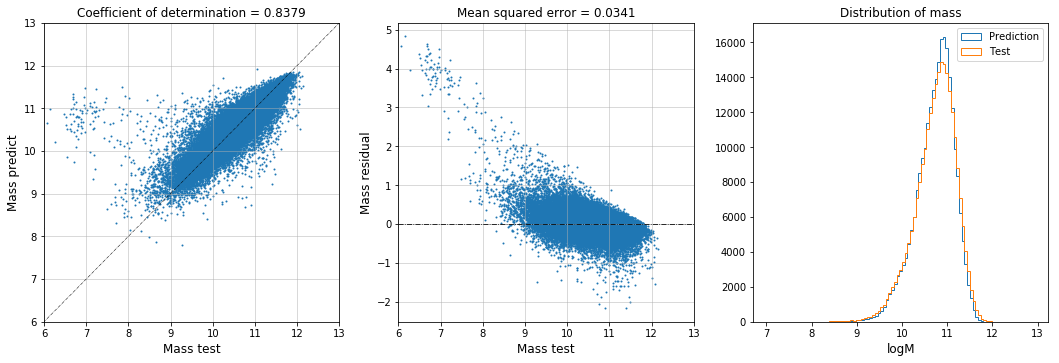

In [513]:
# Plot random forest cross-validation result
mass_plot(rf)

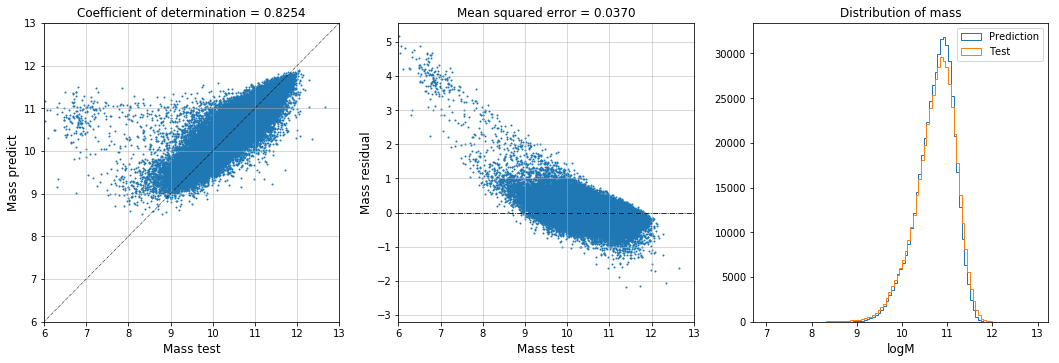

In [532]:
# Plot K nearest neighbor result
mass_plot(knnd_cv)

# Optimize Random Forest parameters

In [359]:
depth = np.arange(8,32,2)
n_tree = np.arange(10,70,5)
rf_opt = np.zeros((len(n_tree),len(depth))).tolist()

In [360]:
start = time.time()
for i in range(len(depth)):
    for j in range(len(n_tree)):
        regrf = ML.RandomForestRegressor(n_estimators=n_tree[j],
                                         max_depth=depth[i],
                                         max_features='auto')
        score = ML.Regressors.CV_scoring(regrf, col_shape, decals['mass_ir'], n_folds=5)
        rf_opt[j][i] = {}
        for key in score:
            rf_opt[j][i][key] = score[key]

end = time.time()
print(end-start)

In [493]:
R2score = np.zeros((len(n_tree),len(depth)))
fit_time = np.zeros((len(n_tree),len(depth)))
for i in range(len(depth)):
    for j in range(len(n_tree)):
        R2score[j][i] = rf_opt[j][i]['R2']
        fit_time[j][i] = rf_opt[j][i]['fit_time']

$R^2$ score and training time plot

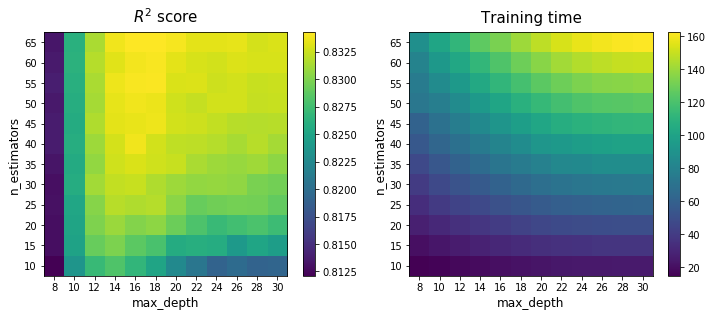

In [496]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 5), ncols=2)
score_plot = ax1.imshow(R2score, origin='lower')
ax1.set_xticks(range(len(depth)))
ax1.set_xticklabels([str(i) for i in depth])
ax1.set_yticks(range(len(n_tree)))
ax1.set_yticklabels(labels=[str(i) for i in n_tree])
fig.colorbar(score_plot, ax=ax1,shrink=.9)
ax1.set_xlabel('max_depth',fontsize=12)
ax1.set_ylabel('n_estimators',fontsize=12)
ax1.set_title(r'${R}^2$ score',fontsize=15,pad=10)

time_plot = ax2.imshow(fit_time, origin='lower')
ax2.set_xticks(range(len(depth)))
ax2.set_xticklabels([str(i) for i in depth])
ax2.set_yticks(range(len(n_tree)))
ax2.set_yticklabels(labels=[str(i) for i in n_tree])
fig.colorbar(time_plot, ax=ax2,shrink=.9)
ax2.set_xlabel('max_depth',fontsize=12)
ax2.set_ylabel('n_estimators',fontsize=12)
ax2.set_title('Training time',fontsize=15,pad=10)

fig.savefig('Optimization.pdf')

# Optimize K Nearest Neighbor parameters

In [606]:
neighbors = np.arange(8,62,2)
knn_opt = np.zeros(len(neighbors)).tolist()
regtest = ML.Regressors(col_shape, decals['mass_ir'])
for i in tqdm(range(len(neighbors))):
    knn = ML.KNeighborsRegressor(n_neighbors=neighbors[i], weights='distance')
    score = ML.Regressors.CV_scoring(knn, regtest._scaled_X, decals['mass_ir'])
    knn_opt[i] = {}
    for key in score:
        knn_opt[i][key] = score[key]


100%|██████████| 2/2 [01:44<00:00, 51.28s/it]


In [607]:
R2score = [score['R2'] for score in knn_opt]
fit_time = [score['fit_time'] for score in knn_opt]
msescore = [score['MSE'] for score in knn_opt]

$R^2$ score and training time plot


Text(0, 0.5, '$R^2$ score')

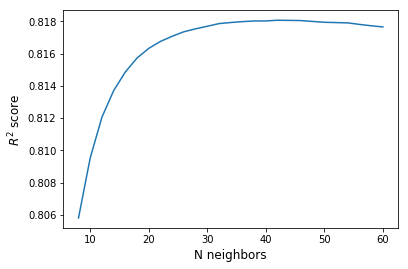

In [610]:
plt.plot(neighbors, R2score)
plt.xlabel('N neighbors', fontsize=12)
plt.ylabel('$R^2$ score', fontsize=12)